In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### load dataset from directory

In [31]:
batch_size = 32
IMG_SIZE = (160, 160)

#train_dir = 'data/images/cls_2/train'

train_dir = 'data/images_balanced/train'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=None,
  shuffle = False,
  image_size=IMG_SIZE,
  batch_size=None)

img, lbl = tuple(zip(*train_ds))

file_paths = train_ds.file_paths
y_patient = ['_'.join(x.split('/')[-1].split('_')[0:2]) for x in file_paths]
file_tensor = tf.convert_to_tensor(y_patient)

indices = tf.range(start=0, limit=tf.shape(lbl)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed = 8)

shuffled_x = tf.gather(img, shuffled_indices)
shuffled_y = tf.gather(lbl, shuffled_indices)
shuffled_file = tf.gather(y_patient, shuffled_indices)

ds_all = tf.data.Dataset.from_tensor_slices((shuffled_x,shuffled_y))
ds_val = ds_all.take(160).batch(32)
ds_train = ds_all.skip(160).batch(32)

val_files = shuffled_file[:160]
ds_val.take(1)

Found 747 files belonging to 2 classes.


<TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Image Preview

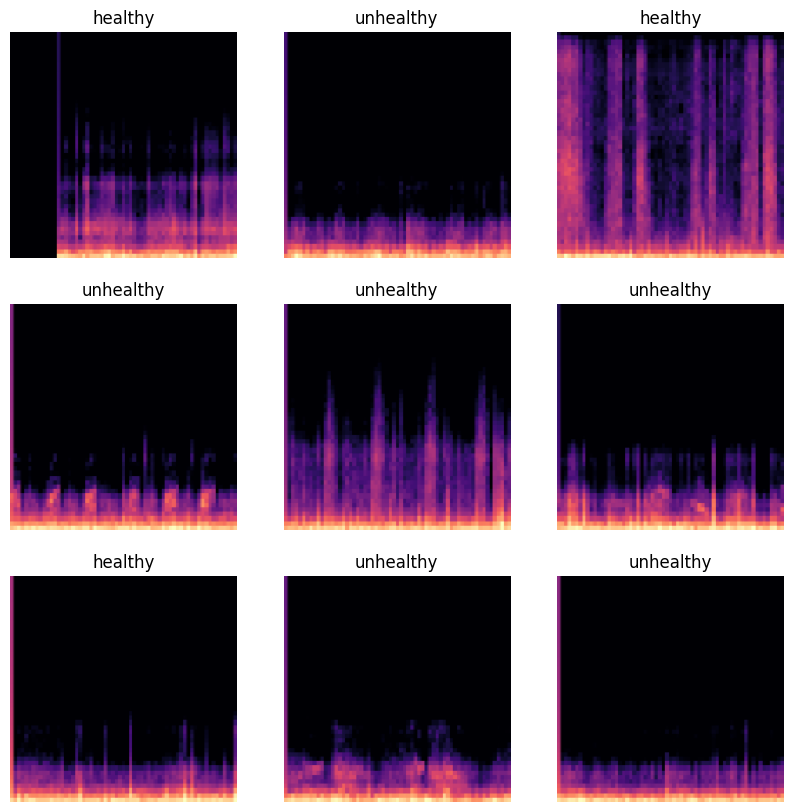

In [32]:
class_names = ['unhealthy', 'healthy']

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

In [33]:
AUTOTUNE = tf.data.AUTOTUNE #find a good allocation of CPU budget automatically

#use buffered prefetching, to yield data from disk without having I/O become blocking
train_ds = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = ds_val.cache().prefetch(buffer_size=AUTOTUNE)


### Data Augmentation

In [34]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### Rescale pixel values

In [35]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model from the pre-trained ResNet50

In [36]:
# Create the base model from the pre-trained model ResNet50V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Freeze the convolutional base

In [37]:
base_model.trainable = False

### Basemodel summary

In [38]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 82, 82, 64)   0           ['conv1_conv[0][0]']    

### Add a classification head

In [39]:
# converts the features (output of base model) to a single 2048-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Add Dense Layer

In [40]:
#No activation Function needed because positive numbers predict class 1, negative numbers predict class 0
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

### Build a model

In [41]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [42]:
#Compile the model before training it. Since there are two classes,
#use tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

### Train the model

In [44]:
initial_epochs = 25

loss0, accuracy0 = model.evaluate(val_ds)

2022-11-14 21:16:58.619809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 80ms/step - loss: 0.7918 - accuracy: 0.4750


In [45]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.47


In [46]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/25


2022-11-14 21:17:09.360447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 5s 135ms/step - loss: 1.0116 - accuracy: 0.4089 - val_loss: 0.7302 - val_accuracy: 0.5813
Epoch 2/25
19/19 [==============================] - 2s 107ms/step - loss: 0.8690 - accuracy: 0.4634 - val_loss: 0.7229 - val_accuracy: 0.4938
Epoch 3/25
19/19 [==============================] - 2s 106ms/step - loss: 0.8265 - accuracy: 0.4957 - val_loss: 0.7195 - val_accuracy: 0.4563
Epoch 4/25
19/19 [==============================] - 2s 107ms/step - loss: 0.8006 - accuracy: 0.5196 - val_loss: 0.7099 - val_accuracy: 0.4813
Epoch 5/25
19/19 [==============================] - 2s 107ms/step - loss: 0.7712 - accuracy: 0.5468 - val_loss: 0.6998 - val_accuracy: 0.5125
Epoch 6/25
19/19 [==============================] - 2s 107ms/step - loss: 0.7477 - accuracy: 0.5656 - val_loss: 0.6920 - val_accuracy: 0.5437
Epoch 7/25
19/19 [==============================] - 2s 107ms/step - loss: 0.7203 - accuracy: 0.6116 - val_loss: 0.6859 - val_accuracy: 0.5375
Epoch 8/25
19/19 

### Learning Curves

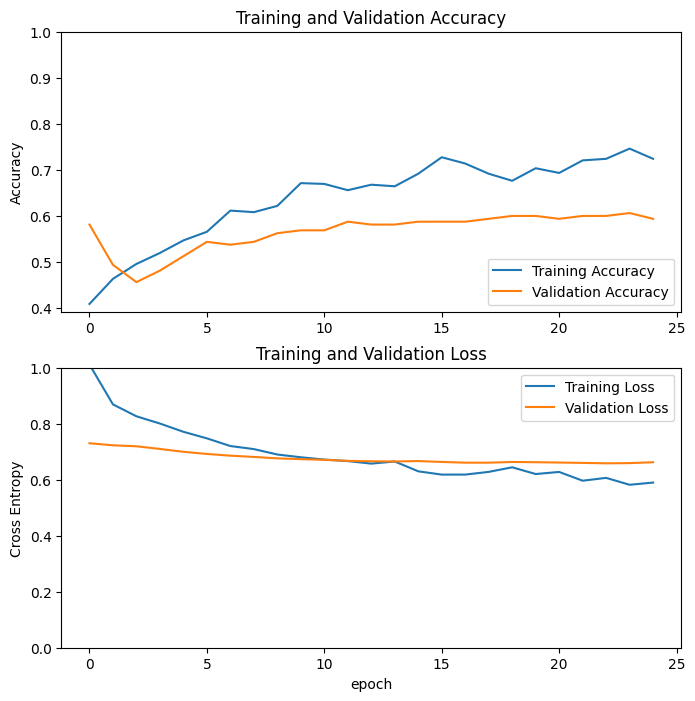

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Note: If you are wondering why the validation metrics are clearly better than the training metrics,
#the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout
#affect accuracy during training. They are turned off when calculating validation loss.

In [48]:
y_pred = model.predict(val_ds)

2022-11-14 21:18:23.985476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [113]:
for x,y in val_ds.as_numpy_iterator():
    print(y)

[0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1]
[1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1]
[1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1]
[1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1]
[1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1]


In [49]:
y = np.concatenate([y for x, y in val_ds], axis=0)
y

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0], dtype=int32)

In [50]:

y_pred = model.predict(val_ds)
y_pred = y_pred.squeeze(-1)
y_pred.shape

(160,)

In [56]:
len(val_files)
names = val_files.numpy()

In [62]:

df = pd.DataFrame([names, y, y_pred], index = ['filename', 'y', 'y_pred']).T
df_patient = df.groupby('filename').mean()
df_patient['y_pred_hard'] = df_patient['y_pred'].round()
df_patient

,y,y_pred,y_pred_hard
filename,,,
b'0_f1',0.0,0.323233,0.0
b'0_f10',0.0,0.541474,1.0
b'0_f101',0.0,0.569725,1.0
b'0_f105',0.0,0.330493,0.0
b'0_f108',0.0,0.389210,0.0
...,...,...,...
b'1_i183',1.0,0.719081,1.0
b'1_i184',1.0,0.458003,0.0
b'1_i208',1.0,0.561867,1.0


In [63]:
confusion_matrix(df_patient.y, df_patient.y_pred_hard)

array([[33, 14],
       [22, 20]])

In [64]:
print(classification_report(df_patient.y, df_patient.y_pred_hard))

              precision    recall  f1-score   support

         0.0       0.60      0.70      0.65        47
         1.0       0.59      0.48      0.53        42

    accuracy                           0.60        89
   macro avg       0.59      0.59      0.59        89
weighted avg       0.59      0.60      0.59        89



### Fine tuning

Read before you go on:

This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.